In [1]:
!pip install huggingface_hub tensorflow matplotlib numpy

import os, zipfile, random
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import StringLookup
import matplotlib.pyplot as plt
from huggingface_hub import snapshot_download
import pandas as pd
from glob import glob


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 153.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 132.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 7.3 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [2]:
dataset_dir = snapshot_download(
    repo_id="YCAI3/HCI_P2",
    repo_type="dataset",
    local_dir="./HCI_Dataset",
    ignore_patterns=[".gitattributes"]
)

print("Dataset downloaded to:", dataset_dir)

zip_path = os.path.join(dataset_dir, "HCI_Dataset.zip")
extract_dir = os.path.join(dataset_dir, "unzipped")

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ Extracted to:", extract_dir)
print("Subfolders:", os.listdir(extract_dir))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/971 [00:00<?, ?B/s]

HCI_Dataset.zip:   0%|          | 0.00/1.29G [00:00<?, ?B/s]

Dataset downloaded to: /content/HCI_Dataset
✅ Extracted to: /content/HCI_Dataset/unzipped
Subfolders: ['HCI_Dataset', '__MACOSX']


In [3]:
base_path = "./HCI_Dataset/unzipped/HCI_Dataset"

image_paths = glob(os.path.join(base_path, "**", "*.jpg"), recursive=True)
print("Total images found:", len(image_paths))
print("Example paths:\n", image_paths[:5])

# Extract label from filename (the word between underscores)
def get_label_from_path(path):
    filename = os.path.basename(path)
    parts = filename.split("_")
    if len(parts) >= 3:
        return parts[1]
    return None

labels = [get_label_from_path(p) for p in image_paths]
data = pd.DataFrame({"path": image_paths, "label": labels})

print("\nRandom samples:")
print(data.sample(5))


Total images found: 609656
Example paths:
 ['./HCI_Dataset/unzipped/HCI_Dataset/140/2/158_portray_59005.jpg', './HCI_Dataset/unzipped/HCI_Dataset/140/2/188_Uncaught_81851.jpg', './HCI_Dataset/unzipped/HCI_Dataset/140/2/92_Inserting_39793.jpg', './HCI_Dataset/unzipped/HCI_Dataset/140/2/34_STIFFENS_74685.jpg', './HCI_Dataset/unzipped/HCI_Dataset/140/2/313_Inst_39881.jpg']

Random samples:
                                                     path          label
337737  ./HCI_Dataset/unzipped/HCI_Dataset/79/6/19_Hun...       Hundreds
98096   ./HCI_Dataset/unzipped/HCI_Dataset/87/4/105_CR...       CRISTINA
262019  ./HCI_Dataset/unzipped/HCI_Dataset/197/6/408_C...        Chewing
471708  ./HCI_Dataset/unzipped/HCI_Dataset/94/3/466_le...  legitimatizes
530489  ./HCI_Dataset/unzipped/HCI_Dataset/75/6/449_Ro...   Romanticists


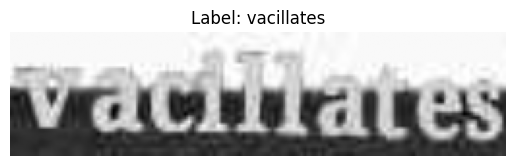

Sample path: ./HCI_Dataset/unzipped/HCI_Dataset/70/2/443_vacillates_83840.jpg
Extracted label: vacillates
File exists: True


In [18]:
# --- Cell 4: Visualize a Random Sample ---
IMG_HEIGHT, IMG_WIDTH = 64, 256  # Wider for text

def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = img / 255.0
    return img

sample_idx = random.randint(0, len(data) - 1)
img = load_and_preprocess_image(data["path"][sample_idx])

plt.imshow(tf.squeeze(img), cmap="gray")
plt.title(f"Label: {data['label'][sample_idx]}")
plt.axis("off")
plt.show()

print("Sample path:", data['path'][sample_idx])
print("Extracted label:", data['label'][sample_idx])
print("File exists:", os.path.exists(data['path'][sample_idx]))


In [19]:
# --- Cell 5: Character Encoding ---
from tensorflow.keras.layers import StringLookup

# Collect all unique characters from labels
all_text = "".join(data["label"].astype(str).tolist())
unique_chars = sorted(list(set(all_text)))

print("Unique characters:", unique_chars)
print("Total unique characters:", len(unique_chars))

# Build lookup tables
char_to_num = StringLookup(vocabulary=unique_chars, oov_token="")
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), invert=True)

# Quick test
example = data["label"].iloc[0]
encoded = char_to_num(tf.strings.unicode_split(example, input_encoding="UTF-8"))
decoded = tf.strings.reduce_join(num_to_char(encoded)).numpy().decode("utf-8")
print(f"Original: {example}\nDecoded : {decoded}")


Unique characters: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Total unique characters: 62
Original: portray
Decoded : onqsqZx


In [20]:
# --- Cell 6: Dataset Creation and Preprocessing ---

IMG_HEIGHT, IMG_WIDTH = 64, 256  # consistent with earlier

def preprocess(path, label):
    # Load image
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = img / 255.0

    # Encode text to integer sequence
    label = char_to_num(tf.strings.unicode_split(label, 'UTF-8'))
    return img, label

paths = data["path"].tolist()
labels = data["label"].tolist()

dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
dataset = dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)


In [21]:
# --- Cell 7: Split Dataset and Batch ---
total_size = len(data)
train_size = int(0.8 * total_size)
val_size   = int(0.1 * total_size)

train_ds = dataset.take(train_size)
val_ds   = dataset.skip(train_size).take(val_size)
test_ds  = dataset.skip(train_size + val_size)

BATCH_SIZE = 64

train_ds = (
    train_ds.padded_batch(BATCH_SIZE, padded_shapes=([64, 256, 1], [None]))
    .prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    val_ds.padded_batch(BATCH_SIZE, padded_shapes=([64, 256, 1], [None]))
    .prefetch(tf.data.AUTOTUNE)
)


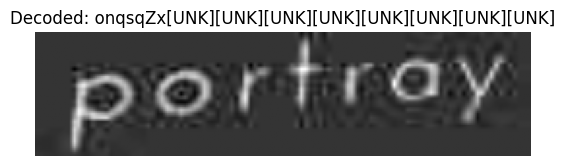

Image shape: (64, 64, 256, 1)
Label shape: (64, 15)


In [22]:
# --- Cell 8: Visualize a Batch and Check Encoding ---

for images, labels in train_ds.take(1):
    idx = 0
    plt.imshow(tf.squeeze(images[idx]), cmap='gray')
    decoded_label = tf.strings.reduce_join(num_to_char(labels[idx])).numpy().decode('utf-8')
    plt.title(f"Decoded: {decoded_label}")
    plt.axis("off")
    plt.show()

print("Image shape:", images.shape)
print("Label shape:", labels.shape)


In [23]:
# --- Cell 9: Define CTC Loss Function ---
import tensorflow as tf

def ctc_loss_func(y_true, y_pred):
    # y_true: padded target labels
    # y_pred: model softmax output (batch, time, vocab)

    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_len = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_len = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_len * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_len * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(
        y_true, y_pred, input_length, label_length,
        ignore_longer_outputs_than_inputs=True  # avoids crash if label > time_steps
    )
    return loss


In [24]:
# --- Cell 10: Build CRNN Architecture ---
from tensorflow import keras
from tensorflow.keras import layers

def build_crnn(rnn_type="lstm"):
    input_img = layers.Input(shape=(64, 256, 1), name="image")

    # --- CNN feature extractor (3 conv blocks, only 2 pooling layers) ---
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(input_img)
    x = layers.MaxPooling2D((2, 2))(x)               # 64x256 -> 32x128
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2, 2))(x)               # 32x128 -> 16x64
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    # width now = 64  (enough time steps for long words)

    # --- Reshape for RNN ---
    x = layers.Reshape(target_shape=(64, 16 * 128))(x)  # (time=64, features=2048)
    x = layers.Dense(128, activation="relu")(x)

    # --- RNN layers ---
    if rnn_type.lower() == "gru":
        x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x)
        x = layers.Bidirectional(layers.GRU(32, return_sequences=True))(x)
    else:
        x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
        x = layers.Bidirectional(layers.LSTM(32, return_sequences=True))(x)

    # --- Output layer ---
    vocab_size = len(char_to_num.get_vocabulary()) + 1
    outputs = layers.Dense(vocab_size, activation="softmax")(x)

    model = keras.models.Model(inputs=input_img, outputs=outputs, name=f"CRNN_{rnn_type.upper()}")
    return model


# Build both variants for summary
crnn_lstm = build_crnn("lstm")
crnn_gru  = build_crnn("gru")

crnn_lstm.summary()


Model: "CRNN_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 256, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 64, 256, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 32, 128, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 32, 128, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 16, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_9 (Reshape)             │ (None, 8, 4096)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 8, 256)         │     4,326,400 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 8, 128)         │       164,352 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8, 64)          │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,591,680 (17.52 MB)

 Trainable params: 4,591,680 (17.52 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# --- Cell 11: Train CRNN (LSTM + Adam, using subset for speed) ---

# You can change .take() sizes for faster/slower training
subset_train = train_ds.take(500)
subset_val   = val_ds.take(100)

crnn_lstm = build_crnn("lstm")
crnn_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=ctc_loss_func
)

history_lstm_adam = crnn_lstm.fit(
    subset_train,
    validation_data=subset_val,
    epochs=10
)


Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/ctc_loss_func/CTCLoss defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.12/dist-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipython-input-1181265731.py", line 8, in <cell line: 0>

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 114, in one_step_on_data

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 61, in train_step

  File "/usr/local/lib/python3.12/dist-packages/keras/src/trainers/trainer.py", line 383, in _compute_loss

  File "/usr/local/lib/python3.12/dist-packages/keras/src/trainers/trainer.py", line 351, in compute_loss

  File "/usr/local/lib/python3.12/dist-packages/keras/src/trainers/compile_utils.py", line 690, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/trainers/compile_utils.py", line 699, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/losses/loss.py", line 67, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/losses/losses.py", line 33, in call

  File "/tmp/ipython-input-3308068405.py", line 12, in ctc_loss_func

  File "/usr/local/lib/python3.12/dist-packages/keras/src/legacy/backend.py", line 666, in ctc_batch_cost

Not enough time for target transition sequence (required: 15, available: 8)0You can turn this error into a warning by using the flag ignore_longer_outputs_than_inputs
	 [[{{node compile_loss/ctc_loss_func/CTCLoss}}]] [Op:__inference_multi_step_on_iterator_19952]

In [ ]:
# --- Cell 12: Train CRNN (LSTM + SGD) ---
crnn_lstm_sgd = build_crnn("lstm")
crnn_lstm_sgd.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9),
    loss=ctc_loss_func
)

history_lstm_sgd = crnn_lstm_sgd.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


In [ ]:
# --- Cell 13: Train CRNN (GRU + Adam) ---
crnn_gru = build_crnn("gru")
crnn_gru.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=ctc_loss_func
)

history_gru_adam = crnn_gru.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


In [ ]:
# --- Cell 14: Train CRNN (GRU + SGD) ---
crnn_gru_sgd = build_crnn("gru")
crnn_gru_sgd.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9),
    loss=ctc_loss_func
)

history_gru_sgd = crnn_gru_sgd.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


In [ ]:
# --- Cell 15: Compare All Models' Training Histories ---
def plot_history(history, title):
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="val")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("CTC Loss")
    plt.legend()
    plt.show()

plot_history(history_lstm_adam, "LSTM + Adam")
plot_history(history_lstm_sgd, "LSTM + SGD")
plot_history(history_gru_adam, "GRU + Adam")
plot_history(history_gru_sgd, "GRU + SGD")